<a href="https://colab.research.google.com/github/Jacob-Francis/SWSG_repo/blob/main/Colab_nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from matplotlib.animation import FuncAnimation

In [488]:
#!apt-get install cuda=10.2.89-1
# %matplotlib inline

# !pip install pykeops[colab] > install.log
# !pip install geomloss[full]
# !apt-get install ffmpeg

import torch
import numpy as np
from geomloss import SamplesLoss
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Device configuration
#pytorch.cuda.alloc.conf = expandable_segments
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)
# torch.set_default_device(device)

In [489]:
def Lloyds(f, N, k=10, Nsteps=3,scali=0.5, epsilon=0.01):

    # Generate initial grid of points for x
    grid_size = int(N**0.5)  # Assuming N is a perfect square
    x = (torch.rand(N, 2,device=device)).detach().requires_grad_(True) # Random points in [-1, 1]
    # Generate fine grid of points y with k*N points
    fine_grid_size = int((k * N)**0.5)
    y = torch.stack(torch.meshgrid(torch.linspace(0, 1, fine_grid_size,device=device),
                                   torch.linspace(0, 1, fine_grid_size,device=device)), dim=-1).reshape(-1, 2)
    y = y[:k * N]

    # Compute weights b proportional to f(y)
    b = f(y)
    b /= b.sum()  # Normalize to make b a probability distribution

    # Uniform weights for points x
    a = torch.full((N,), 1 / N,device=device)

    # Define the entropic OT loss function
    loss_fn = SamplesLoss("sinkhorn", p=2,scaling=scali, blur=epsilon**0.5)

    # Iterative Lloyd's algorithm
    for _ in range(Nsteps):
        # Compute the transport map between x and (y, b)
        loss = loss_fn(a,x,b, y)
        grad = torch.autograd.grad(loss, x)[0]
        x=x.clone().detach().requires_grad_(True)

        # Move points in the direction of the gradient to minimize OT cost
        with torch.no_grad():
            x -= N * grad  # Adjust x by moving in gradient direction

    return x.detach()  # Return points that fit the density function

def init_gaussian(N, k=10, epsilon=0.001,Nsteps=3,scali=0.99,std=[0.2,0.2]):
    def gaussian_density(points, mean=[0, 0], std=[0.1, 0.1]):
        """Evaluates a Gaussian function at given points."""
        dist = torch.distributions.MultivariateNormal(
            torch.tensor(mean,device=device),
            torch.diag(torch.tensor(std,device=device))**2
        )
        return torch.exp(dist.log_prob(points))
    # Run Lloyd's algorithm
    f = lambda y: gaussian_density(y, mean=[0.5, 0.5], std=[0.2, 0.2])  # Gaussian density function
    points = Lloyds(f, N, k=k, Nsteps=Nsteps, epsilon=epsilon)
    return points




In [ ]:
# Parameters
N = 20
N1 = 20  # testing shapes
M = 100
epsilon = 0.01

# Generate G
# G = np.stack([j.flatten() for j in np.meshgrid(
#     np.linspace(1/(2*N), 1 - 1/(2*N), N, endpoint=True),
#     np.linspace(1/(2*N), 1 - 1/(2*N), N, endpoint=True))], axis=-1)
G = init_gaussian(N*N,std=[0.3,0.3])
G = torch.Tensor(G).requires_grad_(True)

# Generate X in the desired format (N * N, 2)
X = np.stack([j.flatten() for j in np.meshgrid(
    np.linspace(1/(2*N1), 1 - 1/(2*N1), N, endpoint=True),
    np.linspace(1/(2*N1), 1 - 1/(2*N1), N, endpoint=True))], axis=-1)

X = torch.Tensor(X).requires_grad_(True).type_as
# Generate Y in the desired format (M * M, 2)
Y = np.stack([j.flatten() for j in np.meshgrid(
    np.linspace(1/(2*M), 1 - 1/(2*M), M, endpoint=True),
    np.linspace(1/(2*M), 1 - 1/(2*M), M, endpoint=True))], axis=-1)
Y = torch.Tensor(Y).requires_grad_(True)


In [ ]:
N = 100
M = 10*N 

debiase,scali,epsilon =False,0.99,0.001

#initialisations
grid_size = int(M ** 0.5)
grid = torch.linspace(0,1, grid_size)
y1, y2 = torch.meshgrid(grid, grid, indexing='ij')
Y = torch.stack([y1.flatten(), y2.flatten()], dim=1)[:M]

G = init_gaussian(N,std=[0.3,0.3])
Y = Y.type_as(G)
X = G.clone().requires_grad_(True)

R here is the reference measuer, though everything so far is just uniformly weighted by the number of points

In [ ]:
loss = SamplesLoss('sinkhorn', p=2, blur=0.01)
lr = 0.5
sigma = 0.01


In [ ]:

def x_adaptation(G, X, Y,loss, sigma=0.01, tol=1e-2):
    err = torch.inf
    count = 0 
    while err > tol:
        # solve one W2 (G, X)
        # L_gx = loss(G, X)
        # L_gx = torch.linalg.norm()
        # [h_gx] = torch.autograd.grad(L_gx, [X])
        h_gx = (X - G) / N
        # solve W2 (X, Y)
        L_xy = loss(X, Y)
        [h_xy] = torch.autograd.grad(L_xy, [X])

        # update X
        update = h_gx + h_xy/sigma
        X = X - lr*N*update / (1 + 1/sigma)

        err = torch.linalg.norm(N*update / (1 + 1/sigma), ord=float('inf'))
        count += 1
    print(count, err)
    return X

def g_speed(G, X, dt, J):
    G = G + dt * (G - X.detach()) @-J
    return G

def x_guess(G, X, dt, J):
    X = X + dt * (G - X.detach()) @-J
    return X


# Dyanmics


# plt.figure(figsize=(8, 6))
# plt.scatter(G[:, 0].cpu(), G[:, 1].cpu(), color='blue', label='G_i', alpha=0.7)
# plt.scatter(Y[:, 0].cpu(), Y[:, 1].cpu(), color='green', s=10, label='Y_j', alpha=0.5)
# plt.scatter(X[:, 0].detach().cpu(), X[:, 1].detach().cpu(), color='red', marker='x', s=80)
# plt.legend()
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.show()

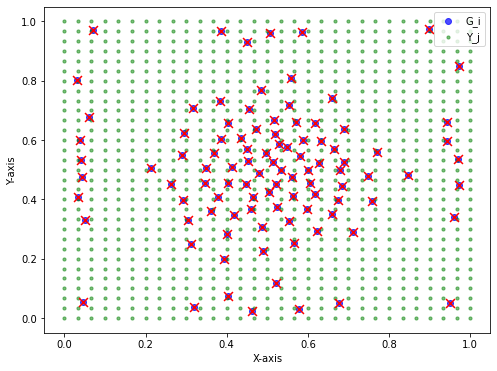

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(G[:, 0].cpu(), G[:, 1].cpu(), color='blue', label='G_i', alpha=0.7)
plt.scatter(Y[:, 0].cpu(), Y[:, 1].cpu(), color='green', s=10, label='Y_j', alpha=0.5)
plt.scatter(X[:, 0].detach().cpu(), X[:, 1].detach().cpu(), color='red', marker='x', s=80)
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

31 tensor(0.0089, device='cuda:0', grad_fn=<AmaxBackward0>)


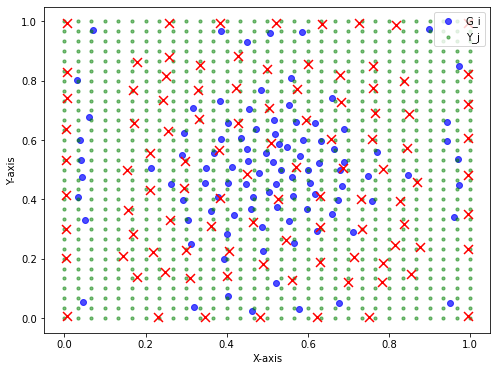

In [ ]:

X = x_adaptation(G, X, Y, sigma=0.01, loss=loss)

# g_speed(G, X, dt, J)

# x_guess(G, X, dt, J)

plt.figure(figsize=(8, 6))
plt.scatter(G[:, 0].cpu(), G[:, 1].cpu(), color='blue', label='G_i', alpha=0.7)
plt.scatter(Y[:, 0].cpu(), Y[:, 1].cpu(), color='green', s=10, label='Y_j', alpha=0.5)
plt.scatter(X[:, 0].detach().cpu(), X[:, 1].detach().cpu(), color='red', marker='x', s=80)
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [ ]:
2/0.05

40.0

In [ ]:
J = -1*torch.Tensor([[0, 1], [-1, 0 ]]).type_as(G)
dt = 0.05
T = 5
N = 200
M = 100*N 

loss = SamplesLoss('sinkhorn', p=2, blur=0.001)
lr = 0.5
sigma = 0.01

#initialisations
grid_size = int(M ** 0.5)
grid = torch.linspace(0,1, grid_size)
y1, y2 = torch.meshgrid(grid, grid, indexing='ij')
Y = torch.stack([y1.flatten(), y2.flatten()], dim=1)[:M]

G = init_gaussian(N,std=[0.3,0.3])
Y = Y.type_as(G)
X = G.clone().requires_grad_(True)


KeyboardInterrupt: 

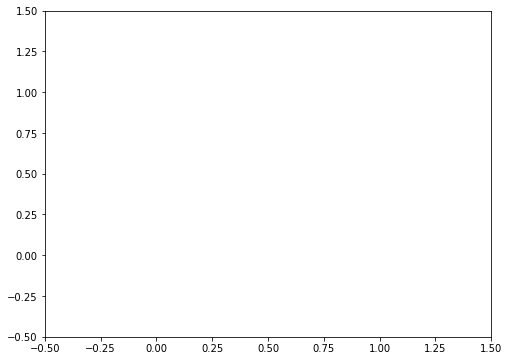

In [ ]:
# Set up the figure and axis for animation
fig, ax = plt.subplots(figsize=(8, 6))
scat_G = ax.scatter(G[:, 0].cpu(), G[:, 1].cpu(), color='blue', label='G_i', alpha=0.7)
scat_Y = ax.scatter(Y[:, 0].cpu(), Y[:, 1].cpu(), color='green', s=5, label='Y_j', alpha=0.5)
scat_X = ax.scatter(X[:, 0].detach().cpu(), X[:, 1].detach().cpu(), color='red', marker='x', s=80)

# Initialize the plot labels
ax.legend()
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Update function for animation
def anim_function(i):
    global X, G
    
    ax.cla()
    ax.set(xlim=[-0.5, 1.5], ylim=[-0.5, 1.5])

    
    # Update X and G
    X = x_adaptation(G, X, Y, sigma=0.001, loss=loss)
    G = g_speed(G, X, dt, J)
    X = x_guess(G, X, dt, J)
    
    # Update scatter plot data without clearing the figure
    scat_G = ax.scatter(G[:, 0].cpu(), G[:, 1].cpu(), color='blue', label='G_i', alpha=0.7)
    # scat_Y = ax.scatter(Y[:, 0].cpu(), Y[:, 1].cpu(), color='green', s=10, label='Y_j', alpha=0.5)
    scat_X = ax.scatter(X[:, 0].detach().cpu(), X[:, 1].detach().cpu(), color='red', marker='x', s=80)

    return scat_G, scat_X

# Create the animation
num_frames = int(T/dt)  # Number of frames for the GIF
anim = FuncAnimation(fig, anim_function, frames=num_frames, interval=300, blit=True)

# Save animation directly as a GIF using PillowWriter
anim.save('animation.gif')#, writer=PillowWriter(fps=3))  # Adjust fps as needed
